In [1]:
library(arrow)
library(mgcv)
library(ggplot2) # 可视化

SAMPLE2 <- read_parquet("SAMPLE2.parquet")
# 数据清理 -------------------------------------
SAMPLE2_clean <- SAMPLE2[, c("ID", "Temperature", "Mortality", "Duration")]

# 数据类型矫正 (重要！)
SAMPLE2_clean$ID <- factor(SAMPLE2_clean$ID)  # 将ID转为因子类型
SAMPLE2_clean$Temperature <- as.numeric(SAMPLE2_clean$Temperature) 

SAMPLE1 <- read_parquet("SAMPLE1.parquet")
# 数据清理 -------------------------------------
SAMPLE1_clean <- SAMPLE1[, c("ID", "Temperature", "Mortality", "Duration")]

# 数据类型矫正 (重要！)
SAMPLE1_clean$ID <- factor(SAMPLE1_clean$ID)  # 将ID转为因子类型
SAMPLE1_clean$Temperature <- as.numeric(SAMPLE1_clean$Temperature) 


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Warning message:
“package ‘mgcv’ was built under R version 4.3.3”
Loading required package: nlme

Warning message:
“package ‘nlme’ was built under R version 4.3.3”
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


Warning message:
“package ‘car’ was built under R version 4.3.3”
Loading required package: carData

Warning message:
“package ‘carData’ was built under R version 4.3.3”


SAMPLE2$Temperature    SAMPLE2$Duration 
           1.435512            1.435512


'gamm' based fit - care required with interpretation.
Checks based on working residuals may be misleading.
Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                 k'  edf k-index p-value    
s(Temperature) 4.00 3.98    0.13  <2e-16 ***
s(Duration)    9.00 8.11    0.74  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


pdf 
  2

,edf,Ref.df,F,p-value
s(Temperature),3.982633,3.982633,638.07046,0
s(Duration),8.108331,8.108331,39.15455,0


            Variance                              StdDev     Corr         
g =         pdIdnot(Xr - 1)                                               
Xr1          22.40325473                           4.7332077              
Xr2          22.40325473                           4.7332077              
Xr3          22.40325473                           4.7332077              
g.0 =       pdIdnot(Xr.0 - 1)                                             
Xr.01       108.14889725                          10.3994662              
Xr.02       108.14889725                          10.3994662              
Xr.03       108.14889725                          10.3994662              
Xr.04       108.14889725                          10.3994662              
Xr.05       108.14889725                          10.3994662              
Xr.06       108.14889725                          10.3994662              
Xr.07       108.14889725                          10.3994662              
Xr.08       108.14889725 

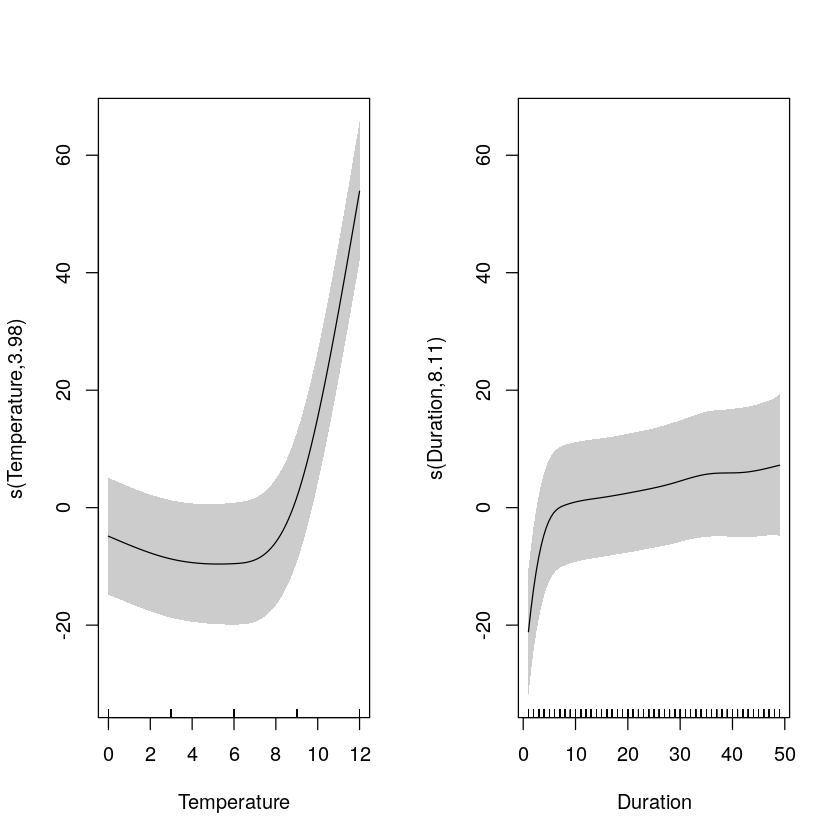

In [2]:

library(car)
SAMPLE2 <- SAMPLE2[SAMPLE2$pCO2 == 400,]
vif_test <- lm(SAMPLE2$Mortality ~ SAMPLE2$Temperature + SAMPLE2$Duration)
vif(vif_test)
# 锁定k=5（等于温度唯一值数量）
model_atl <- gamm(
  Mortality ~ s(Temperature, k=5, bs="cr") +  # 三次回归样条更稳定
              s(Duration, k=10, bs="ps"),     # P-样条处理Duration的惩罚
  random = list(ID = ~ 1 + Temperature + Duration),      # 允许温度效应随ID变化
  data = SAMPLE2_clean,
  control = lmeControl(msMaxIter=1000, niterEM=300),  # 增强收敛
  method = "REML"         # 更优的方差估计方法
)

# # 强制样条固定自由度（牺牲灵活性保稳定）
# model_fixed <- gamm(
#   Mortality ~ s(Temperature, k=5, fx=TRUE) +  # fx=TRUE关闭惩罚
#               s(Duration, k=8, fx=TRUE),
#   random = list(ID = ~1),
#   data = SAMPLE2_clean
# )

# 诊断专用代码
pdf("Optimized_Model_Diagnostics_Atl.pdf", width=8, height=6)
par(mfrow=c(2,2))
gam.check(model_atl$gam, old.style=TRUE)  # 经典诊断面板
dev.off()

# 提取关键参数
summary(model_atl$gam)$s.table          # 固定效应详细信息
VarCorr(model_atl$lme)                  # 随机效应方差组分

# 有限外推可视化
plot(model_atl$gam, pages=1, shade=TRUE, seWithMean=TRUE)

save(model_atl, file = "model_atlantic.rda")





'gamm' based fit - care required with interpretation.
Checks based on working residuals may be misleading.
Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                 k'  edf k-index p-value    
s(Temperature) 4.00 3.91    0.04  <2e-16 ***
s(Duration)    9.00 7.70    1.20       1    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


pdf 
  2

,edf,Ref.df,F,p-value
s(Temperature),3.906514,3.906514,108.8124,0
s(Duration),7.699854,7.699854,334.3570,0


            Variance                              StdDev     Corr         
g =         pdIdnot(Xr - 1)                                               
Xr1           2.15590958                           1.4683016              
Xr2           2.15590958                           1.4683016              
Xr3           2.15590958                           1.4683016              
g.0 =       pdIdnot(Xr.0 - 1)                                             
Xr.01        42.51654067                           6.5204709              
Xr.02        42.51654067                           6.5204709              
Xr.03        42.51654067                           6.5204709              
Xr.04        42.51654067                           6.5204709              
Xr.05        42.51654067                           6.5204709              
Xr.06        42.51654067                           6.5204709              
Xr.07        42.51654067                           6.5204709              
Xr.08        42.51654067 

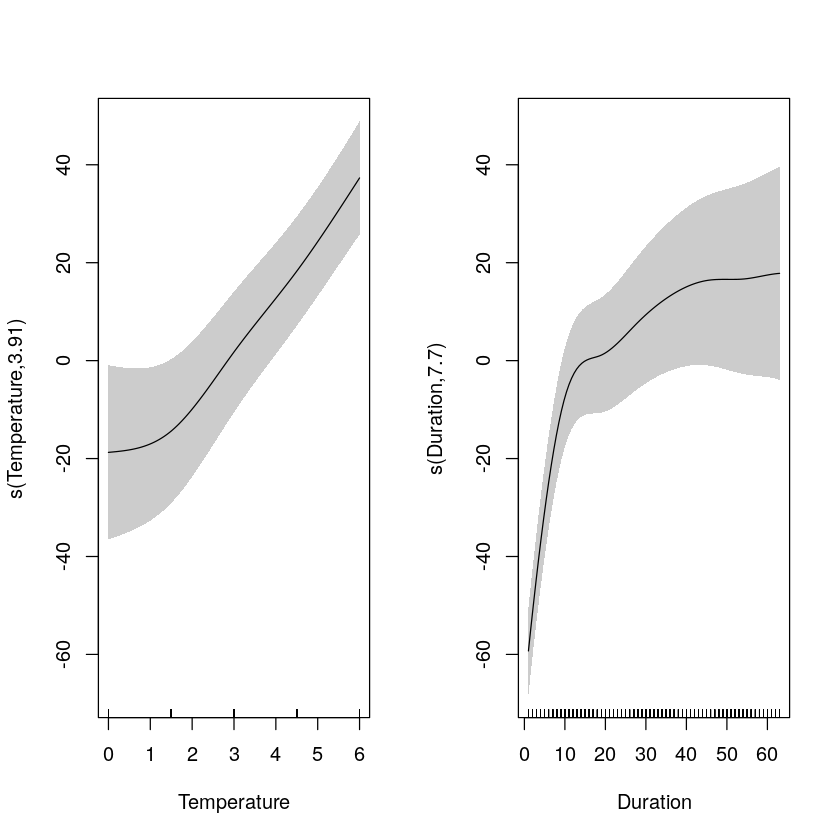

In [3]:
# 锁定k=5（等于温度唯一值数量）
model_pol <- gamm(
  Mortality ~ s(Temperature, k=5, bs="cr") +  # 三次回归样条更稳定
              s(Duration, k=10, bs="ps"),     # P-样条处理Duration的惩罚
  random = list(ID = ~ 1 + Temperature + Duration),      # 允许温度效应随ID变化
  data = SAMPLE1_clean,
  control = lmeControl(msMaxIter=1000, niterEM=300),  # 增强收敛
  method = "REML"         # 更优的方差估计方法
)

# # 强制样条固定自由度（牺牲灵活性保稳定）
# model_fixed <- gamm(
#   Mortality ~ s(Temperature, k=5, fx=TRUE) +  # fx=TRUE关闭惩罚
#               s(Duration, k=8, fx=TRUE),
#   random = list(ID = ~1),
#   data = SAMPLE2_clean
# )

# 诊断专用代码
pdf("Optimized_Model_Diagnostics_Pol.pdf", width=8, height=6)
par(mfrow=c(2,2))
gam.check(model_pol$gam, old.style=TRUE)  # 经典诊断面板
dev.off()

# 提取关键参数
summary(model_pol$gam)$s.table          # 固定效应详细信息
VarCorr(model_pol$lme)                  # 随机效应方差组分

# 有限外推可视化
plot(model_pol$gam, pages=1, shade=TRUE, seWithMean=TRUE)

save(model_pol, file = "model_polar.rda")

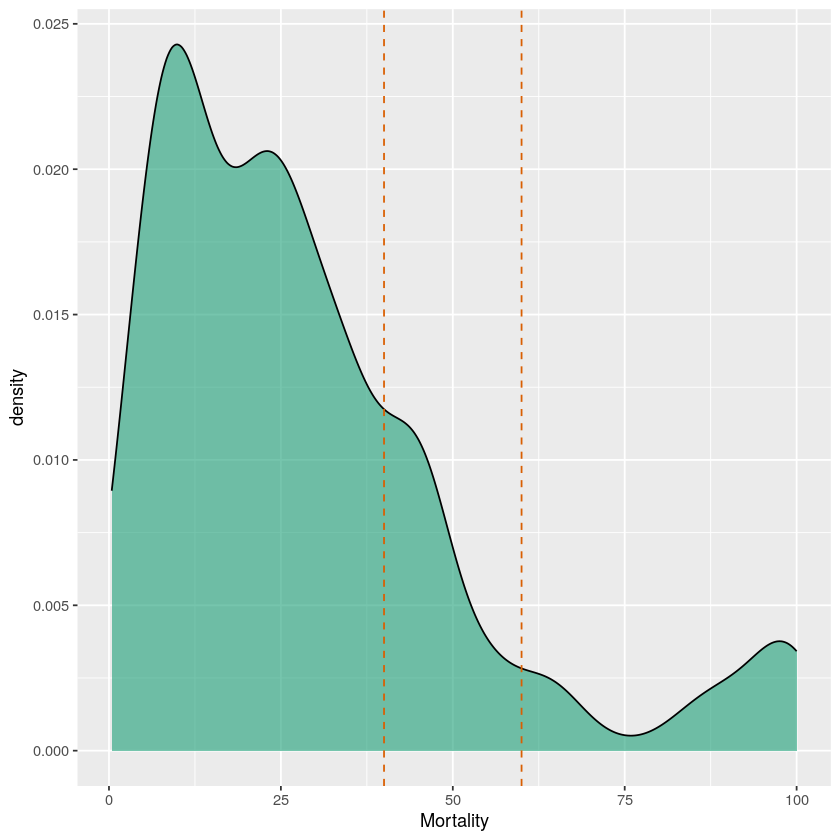

In [4]:
# 查看Mortality分布特征
ggplot(SAMPLE2_clean, aes(Mortality)) + 
  geom_density(fill="#1b9e77", alpha=0.6) +
  geom_vline(xintercept=c(40,60), linetype="dashed", color="#d95f02")

# # 典型输出判断标准：
# - 若双峰分布在40以下和60以上 → 数据本身两极分化
# - 若连续分布但有40-60的空白区 → 数据采集/实验设计问题


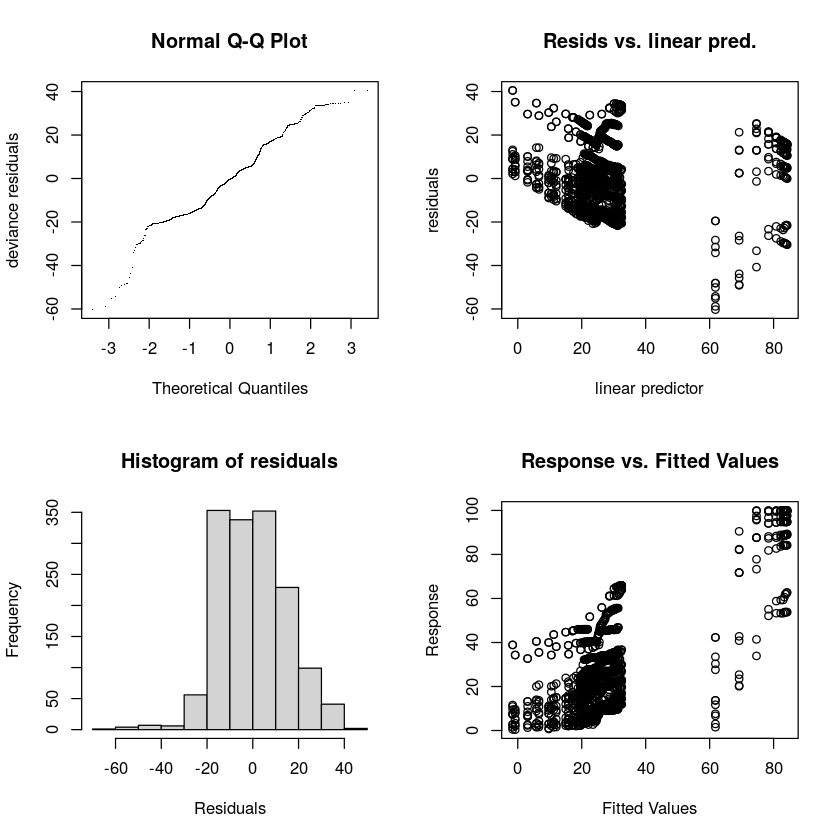

In [5]:
# 输出所有可用模型信息
sink("Full_Model_Summary_atl.txt")
print(summary(model_atl$gam))
print(summary(model_atl$lme))
print(gam.check(model_atl$gam))
sink()


pdf 
  2

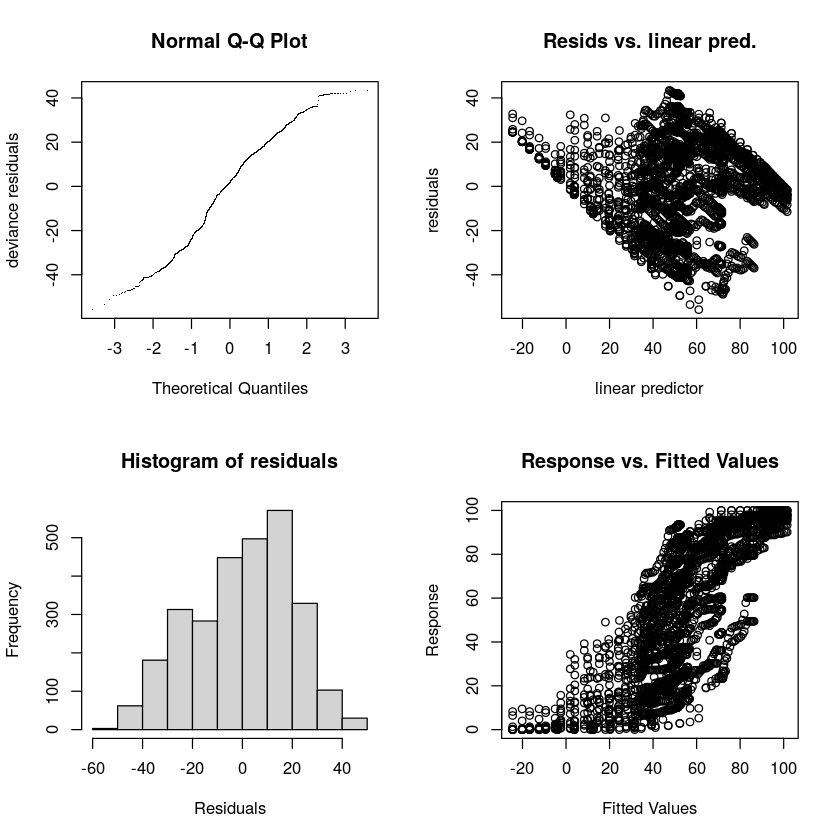

In [30]:
# 输出所有可用模型信息
sink("Full_Model_Summary_pol.txt")
print(summary(model_pol$gam))
print(summary(model_pol$lme))
print(gam.check(model_pol$gam))
sink()

# 创建合并图形并导出为PNG
png("Rplot.png", width=1500, height=1000, res=120)

# 使用par设置多图布局，2行3列，并增大字体加粗
par(mfrow=c(2,3),
    cex.axis=1.3, font.axis=2,    # 坐标轴刻度文字
    cex.lab=1.5, font.lab=2,      # 坐标轴标签
    cex.main=1.8, font.main=2)    # 图表标题

# 绘制温度的影响（第一行左侧）
plot(model_pol$gam, select = 1)
title(bquote(bold("a)")), adj=0, cex.main=2)

# 残差对拟合值（第一行中间）
res <- residuals(model_pol$gam)
fit <- fitted(model_pol$gam)
plot(fit, res, xlab="Fitted Values", ylab="Residuals")
title(bquote(bold("b)")), adj=0, cex.main=2)

# QQ图（第一行右侧）
qqnorm(res, main="", cex=1.2)
title(bquote(bold("c)")), adj=0, cex.main=2)
qqline(res, col="red", lwd=2)

# 绘制持续时间的影响（第二行左侧）
plot(model_pol$gam, select = 2)
title(bquote(bold("d)")), adj=0, cex.main=2)

# 直方图（第二行中间）
hist(res, main="", xlab="Residuals")
title(bquote(bold("e)")), adj=0, cex.main=2)

# Scale-Location图（第二行右侧）
plot(fit, sqrt(abs(res)), xlab="Fitted Values", ylab="sqrt(|Residuals|)")
title(bquote(bold("f)")), adj=0, cex.main=2)

dev.off()


In [7]:
# library(mgcv)


# # Step 1: 定义自然样条模型（抗外推）
# final_model <- gamm(
#   Y ~ s(Temperature, k=5, bs="cs") + s(Duration, k=10),
#   random = list(group_var = ~1),  # 根据实际数据修改
#   data = SAMPLE2
# )

# # Step 2: 强制温度预测范围约束（即使原始数据允许外推）
# predict_safely <- function(model, newdata) {
#   newdata$Temperature <- pmax(newdata$Temperature, 0)  # 禁止温度外推至训练下限以下
#   predict(model$gam, newdata)
# }

# # Step 3: 生成外推预测并绘图
# newdata_ext <- expand.grid(Temperature=seq(-2, 8, 0.5), Duration=median(data$Duration))
# pred_ext <- predict_safely(final_model, newdata_ext)
# plot(pred_ext ~ newdata_ext$Temperature, type="l", col="blue", 
#      xlab="Temperature", ylab="Predicted Y")
# abline(v=c(0,6), lty=2, col="red")


png 
  3

pdf 
  2

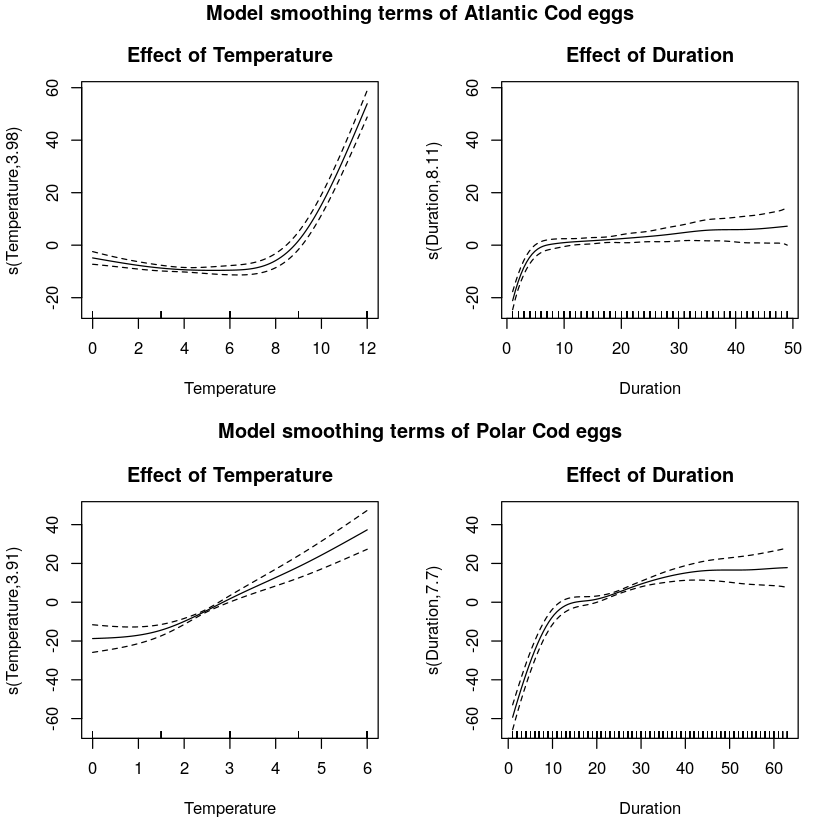

In [8]:




# 设置在一个图形窗口中绘制两张图
par(mfrow = c(2, 2))

# 绘制温度(Temp)的影响
plot(model_atl$gam, select = 1)

title("Effect of Temperature", line = 1, adj = 0.5)

# 绘制年龄(Age)的影响
plot(model_atl$gam, select = 2)

title("Effect of Duration", line = 1, adj = 0.5)

# 添加总标题
title("Model smoothing terms of Atlantic Cod eggs", outer = TRUE, line = -1)


# 绘制温度(Temp)的影响
plot(model_pol$gam, select = 1 )

title("Effect of Temperature", line = 1, adj = 0.5)

# 绘制年龄(Age)的影响
plot(model_pol$gam, select = 2)

title("Effect of Duration", line = 1, adj = 0.5)

# 添加总标题
title("Model smoothing terms of Polar Cod eggs", outer = TRUE, line = -22)

# 保存图形
dev.copy(png, "model_smoothing terms.png")
dev.off()


In [9]:
summary(model_atl$gam)



Family: gaussian 
Link function: identity 

Formula:
Mortality ~ s(Temperature, k = 5, bs = "cr") + s(Duration, k = 10, 
    bs = "ps")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   29.049      5.013   5.795 8.36e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F p-value    
s(Temperature) 3.983  3.983 638.07  <2e-16 ***
s(Duration)    8.108  8.108  39.16  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.579   
  Scale est. = 92.035    n = 1488

In [10]:
summary(model_pol$gam)


Family: gaussian 
Link function: identity 

Formula:
Mortality ~ s(Temperature, k = 5, bs = "cr") + s(Duration, k = 10, 
    bs = "ps")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   53.504      6.502   8.229 2.85e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df     F p-value    
s(Temperature) 3.907  3.907 108.8  <2e-16 ***
s(Duration)    7.700  7.700 334.4  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.584   
  Scale est. = 118.09    n = 2820